# Introduction to the Article Code:

This is the code used for the article posted on Medium.com. If you would like to know more about it click the link: [CRISP-DM Regression Analysis in Python](https://medium.com/p/ade4b74bdc85/edit)

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from helper import cleaning_dollar
from helper import apply_regression_models
from helper import unzip_files
from pandas.plotting import table
from sklearn.preprocessing import OneHotEncoder
from helper import iqr_outlier_detect
from helper import AnalysisStatus

<a id="extract"></a>

# Data Understanding: Extracting and Merging the Data

## Extracting Zip File

In [3]:
# getting zip file name
data_zip = os.listdir('data')
data_zip

['calendar.csv', 'listings.csv', 'reviews.csv', 'seattle.zip']

In [4]:
# extracting datasets
file_names = unzip_files(data_zip)
file_names

calendar.csv already extracted!
listings.csv already extracted!
reviews.csv already extracted!


['calendar.csv', 'listings.csv', 'reviews.csv', 'seattle.zip']

## Calendar

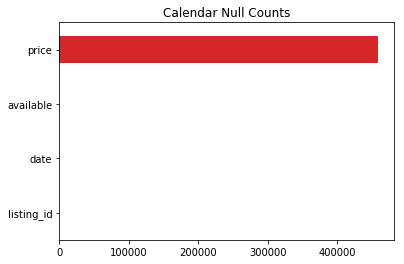

In [5]:
# Extracting the calendar dataset
df_calendar = pd.read_csv('data\calendar.csv')

# Extracting the listings dataset
target_col = ['id', 'accommodates', 'bedrooms', 'cleaning_fee', 'property_type']
df_listings = pd.read_csv('data\listings.csv')[target_col]

# Calculating null values
null_calendar = df_calendar.isnull().sum()
null_listings = df_listings.isnull().sum()

# Show Nulls on Graph
null_calendar.plot.barh(title='Calendar Null Counts');

In [6]:
pd.to_datetime(df_calendar.date).describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

The only feature in the calendar dataset having nulls is price.

## Listings

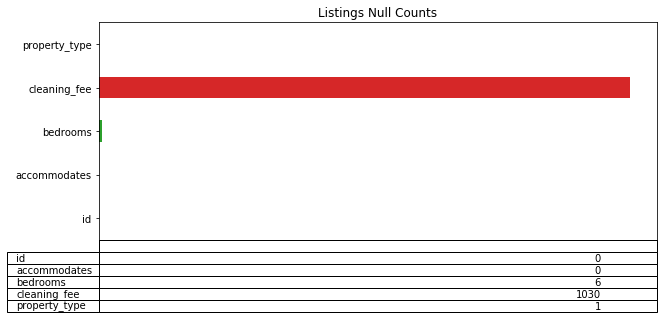

In [7]:
# Plot settings
ax = plt.subplot(111, frame_on=True) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

# Adding Table
table(ax, null_listings)

# Showing Graph
null_listings.plot.barh(title='Listings Null Counts', figsize=(10,4));

The most noticeable feature having nulls is the cleaning fee. Bedrooms and property types have insignificant null values. However, instead of just removing these, we are imputing them for the sake of example. 

<a id="tran"></a>

# Data Preparation: Transforming and Cleaning the Data

## Calendar

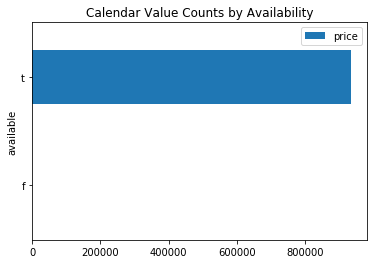

In [8]:
# Cleaning price
df_calendar.loc[:, 'price'] = df_calendar.price.str.findall(
    '[^$,]').str.join('').astype(float)

# Grouping prices by the available feature
df_calendar.groupby('available').count()[['price']].plot.barh(
    title="Calendar Value Counts by Availability");

Where the prices are null in the calendar dataset, the availability is false (f). This means that the unavailable listings have no price at all. The nulls here are meaningful.

In [9]:
# Dropping where available is f
df_calendar = df_calendar.where(lambda x: x.available=='t').dropna()

# Kepp only usefull features for the analysis
df_calendar = df_calendar[['listing_id', 'price', 'date']]

We ended up dropping the null prices because we will waste our time predicting $0 prices when the listing is not available. Thus, the availability feature ended populated with just True conditions (t). So we dropped it.

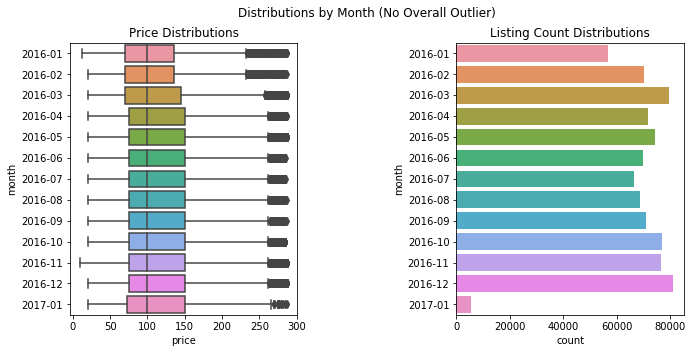

In [10]:
# Converting date to date time
df_calendar.loc[:, 'date'] = pd.to_datetime(df_calendar.date)

# Adding the months ot sort on Graph
df_calendar.loc[:, 'month'] = df_calendar.date.dt.to_period("M").astype(str)

# Plotting settings
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))

plt.suptitle('Distributions by Month (No Overall Outlier)')
plt.subplots_adjust(wspace=.7)

# Statistical outlier removal
upper_quartile = df_calendar.price.quantile(.75)
lower_quartile = df_calendar.price.quantile(.25)
interquartile =  upper_quartile - lower_quartile
lower_whisker = lower_quartile - interquartile * 1.5
upper_whisker = upper_quartile + interquartile * 1.5

# Data without outlier to plot
df_calendar_noout = df_calendar.query(
    f"price<={upper_whisker} and price>={lower_whisker}")

# Plotting 
ax[0].set_title('Price Distributions')
sns.boxplot(x='price', y='month', data=df_calendar_noout, ax=ax[0]);

ax[1].set_title('Listing Count Distributions')
sns.countplot(y='month', data=df_calendar_noout, ax=ax[1]);

In [11]:
df_calendar.date.describe()

count                  934542
unique                    365
top       2017-01-01 00:00:00
freq                     2922
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

We answered the first business question with this graphs. Which months have higher prices? Here, we are talking about the listing prices. Thus, to show each particular prices by month (not aggregates), the best way is to provide their distributions. However, to know how complete is the data, we needed to check the listing counts per month. For example, January 2017 is definitely not completed. In fact it only has 2 days of data. Perhaps after completing the month, January 2017 ends up being higher than December 2016. Thus, we cannot use January 2017 to compare.

In [12]:
# Save date references
dates = pd.Series(df_calendar.date.unique())
date_order = pd.Series(df_calendar.date.unique()).rank()
date_ref_df = pd.concat([dates, date_order], axis=1)
date_ref_df.columns = ['dates', 'date_order']

# Transforming dates to ordered values
df_calendar.loc[:, 'date'] = df_calendar.date.rank(method='dense')

# Dropping irrelevant columns
df_calendar.drop('month', axis=1, inplace=True)

We saved the original dates and the related ranking for reference.

## Listings 

In [13]:
# Cleaning cleaning fee
df_listings.loc[:, 'cleaning_fee'] = df_listings.cleaning_fee.str.findall(
    '[^$,]').str.join('').astype(float)

The only field needing cleanup is the cleaning fee.

<a id="impute"></a>

# Data Preparation: Imputation of the Data

## Bedroom Imputations

In [14]:
# Get mode by group into dictionary
mode = df_listings.groupby('property_type').bedrooms.apply(
    lambda x: x.value_counts().index[0]).to_dict()

# Assign the mode by mapping
mode_fill = df_listings.assign(
    bedrooms=lambda x: x.property_type.map(mode)).bedrooms

# Fill the nulls with respective modes by property_type
df_listings.bedrooms.fillna(mode_fill, inplace=True)

# Show modes by category
pd.DataFrame(mode, index=[0]).T.rename(columns={0: 'Mode'})

,Mode
Apartment,1.0
Bed & Breakfast,1.0
Boat,1.0
Bungalow,0.0
Cabin,1.0
Camper/RV,1.0
Chalet,1.0
Condominium,1.0
Dorm,1.0
House,1.0


By chance, most of property type's most common number of bedrooms is 1.

## Cleaning Fees Imputations

In [15]:
df_listings.cleaning_fee.fillna(0, inplace=True)

We are assuming null cleaning fees are just $0 cleaning fees.

## Property Type Sparsity Groupings

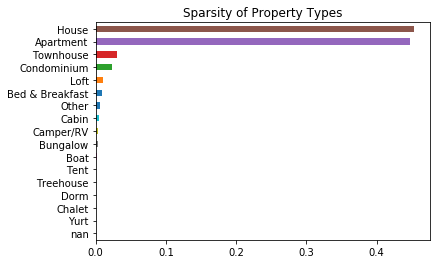

In [16]:
df_listings.property_type.value_counts(
    normalize=True, dropna=False, ascending=True
    ).plot.barh(title='Sparsity of Property Types');

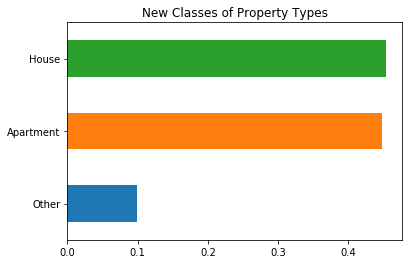

In [17]:
# Leaving relevant classes and assigning all other to Other
fn_keep_labels = lambda x: x.str.contains('House|Apartment')
df_listings.loc[:, 'property_type'] = df_listings.property_type.where(
    fn_keep_labels).fillna('Other')

# Plotting new classes
df_listings.property_type.value_counts(
    normalize=True, dropna=False, ascending=True
    ).plot.barh(title='New Classes of Property Types');

<a id="encode"></a>

# Data Preparation: Encoding the Data

In [18]:
# Instantiating Encoder
encoder = OneHotEncoder()

# Encoding property types
encode_matrix = encoder.fit_transform(df_listings[['property_type']])

# Converting encoded data to dataframe
endoce_df = pd.DataFrame(encode_matrix.toarray(), columns=encoder.categories_[0])

# Adding columns to dataframe
df_listings = pd.concat([df_listings, endoce_df], axis=1)

In [19]:
endoce_df.head()

,Apartment,House,Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [20]:
df_listings.head()

,id,accommodates,bedrooms,cleaning_fee,property_type,Apartment,House,Other
0,241032,4,1.0,0.0,Apartment,1.0,0.0,0.0
1,953595,4,1.0,40.0,Apartment,1.0,0.0,0.0
2,3308979,11,5.0,300.0,House,0.0,1.0,0.0
3,7421966,3,0.0,0.0,Apartment,1.0,0.0,0.0
4,278830,6,3.0,125.0,House,0.0,1.0,0.0


The property type was encoded as dummy variables so the model can run.

<a id="assess"></a>

In [21]:
# Dropping original column
df_listings.drop('property_type', axis=1, inplace=True)

#  Data Preparation: Assessing Correlations

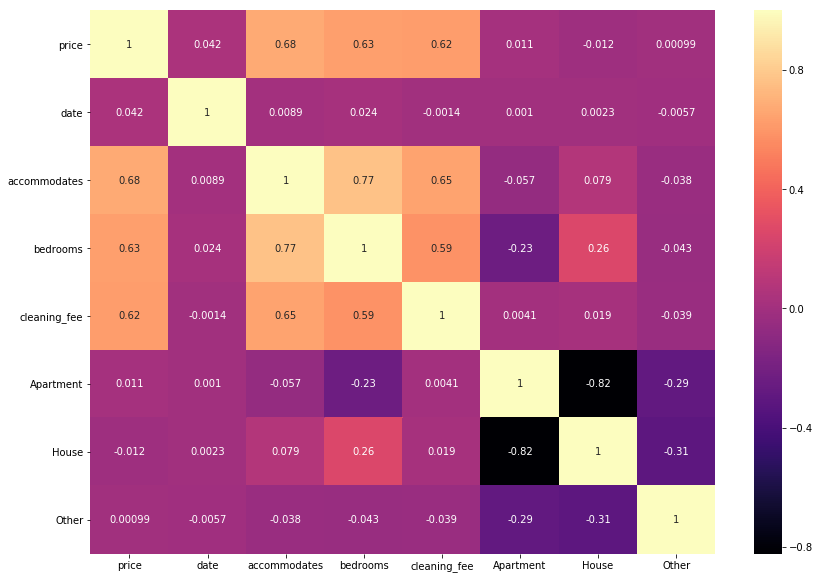

In [23]:
# Instantiating analysis class
analysis = AnalysisStatus(df_calendar, df_listings)

# Dropping keys
analysis.df_merged.drop(['id', 'listing_id'], axis=1, inplace=True)

# Plotting correlations
analysis.correlation_heatmap()

# Creating the final Seattle data
df_seattle = analysis.df_merged

The encoded columns ended up not providing any value to the model. In addition, two of them have high multicollinearity. Thus, we are removing them.

In [24]:
# Droping encoded columns
df_seattle.drop(['Apartment', 'House', 'Other'], axis=1, inplace=True)

<a id="models"></a>

# Model: Applying and Evaluating

## Model Evluation

In [56]:
apply_regression_models(df_seattle, 'price')

SPLIT 1: TRAIN 0 to 233636 or 25.00% | TEST 233637 to 467271 or 25.00%
----------------------------------------------------------------------
	Model: Linear Regression
	Coefficient of Determinaion: 53.97% 
	Mean Squared Errors: 5,249.84 
	Durbin-Watson: 2.0
----------------------------------------------------------------------
	Model: Random Forest Regressor
	Coefficient of Determinaion: 68.63% 
	Mean Squared Errors: 3,578.21 
	Durbin-Watson: 1.9
______________________________________________________________________
SPLIT 2: TRAIN 0 to 467271 or 50.00% | TEST 467272 to 700906 or 25.00%
----------------------------------------------------------------------
	Model: Linear Regression
	Coefficient of Determinaion: 54.44% 
	Mean Squared Errors: 5,965.83 
	Durbin-Watson: 1.9
----------------------------------------------------------------------
	Model: Random Forest Regressor
	Coefficient of Determinaion: 65.20% 
	Mean Squared Errors: 4,556.27 
	Durbin-Watson: 2.0
___________________________

{'LinearModel': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'EnsembleModel': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False)}

The score is better for the Random Forest Regression. However, we can do better by removing outliers.

## Evaluation: Outlier Analysis

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64


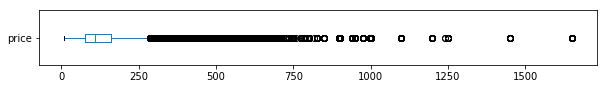

(-52.5, 287.5)

In [57]:
iqr_outlier_detect(df_seattle.price)

Indeed, there are many outliers in this dataset. However, let's start by looking for patterns in the top outliers.

In [58]:
df_calendar.query("price>1100").groupby(['listing_id', 'price']).size().to_frame('ListingCount')

ListingCount
listing_id price               
2715623.0  1240.0             2
3308979.0  1250.0            15
           1450.0            28
           1650.0            91
7733192.0  1199.0            71

We can quickly observe that most of the outliers are concentrated in one listing for the same host. 

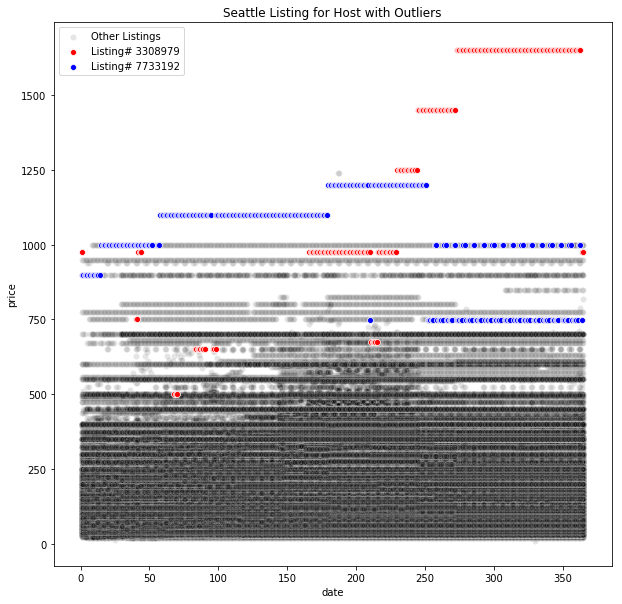

In [59]:
plt.figure(figsize=(10, 10));

data = df_calendar 
plt.title("Seattle Listing Prices Over Date Numbers")
sns.scatterplot(x='date', 
                y='price', 
                data=data,
                color='black',
                alpha=.1, 
                label='Other Listings');

data = df_calendar.query("listing_id == '3308979'")
plt.title("Seattle Listing for Host with Outliers")
sns.scatterplot(x='date', 
                y='price', 
                data=data,
                color='red',
                label='Listing# 3308979');

data = df_calendar.query("listing_id == '7733192'")
plt.title("Seattle Listing for Host with Outliers")
sns.scatterplot(x='date', 
                y='price', 
                data=data,
                color='blue',
                label='Listing# 7733192');

We can see the density is at the bottom of the graph and there are some listings unlikely to happen at the top. In fact, these points at the top are concentrated in two listings. This is unlikely to happen in general, so it is bad for prediction. We are removing those ones.

In [60]:
df_seattle = df_seattle.query("price < 1100")

count    934335.000000
mean        137.657430
std         103.239032
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1099.000000
Name: price, dtype: float64


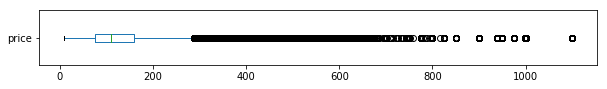

(-52.5, 287.5)

In [61]:
iqr_outlier_detect(df_seattle.price)

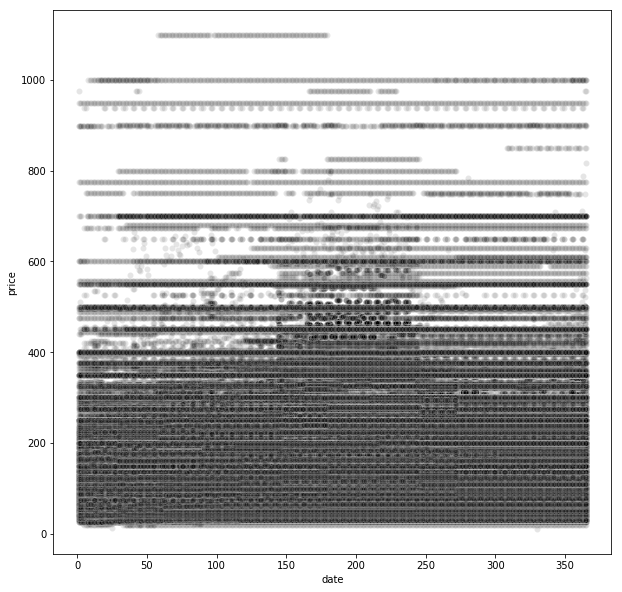

In [62]:
plt.figure(figsize=(10, 10));

sns.scatterplot(x='date', 
                y='price', 
                data=df_seattle,
                color='black',
                alpha=.1);

We still observe some outliers, but these outliers are part of the noise and valid for the analysis.

## Evaluation: Re-run Model with Outliers Removed

In [65]:
apply_regression_models(df_seattle, 'price')

SPLIT 1: TRAIN 0 to 233585 or 25.00% | TEST 233586 to 467168 or 25.00%
----------------------------------------------------------------------
	Model: Linear Regression
	Coefficient of Determinaion: 54.07% 
	Mean Squared Errors: 5,213.99 
	Durbin-Watson: 2.0
----------------------------------------------------------------------
	Model: Random Forest Regressor
	Coefficient of Determinaion: 68.72% 
	Mean Squared Errors: 3,550.45 
	Durbin-Watson: 1.9
______________________________________________________________________
SPLIT 2: TRAIN 0 to 467168 or 50.00% | TEST 467169 to 700751 or 25.00%
----------------------------------------------------------------------
	Model: Linear Regression
	Coefficient of Determinaion: 55.04% 
	Mean Squared Errors: 5,598.93 
	Durbin-Watson: 1.9
----------------------------------------------------------------------
	Model: Random Forest Regressor
	Coefficient of Determinaion: 69.43% 
	Mean Squared Errors: 3,806.45 
	Durbin-Watson: 2.0
___________________________

{'LinearModel': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'EnsembleModel': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False)}

We don't see substantial improvement in the models to justify the removal of the outliers. With them or without them, the model performs about the same.